In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn

Anomaly detection in time series is about identifying unusual patterns or outliers that do not conform to expected behavior. This is vital in domains like finance (fraud detection), network security, IoT monitoring, and healthcare.

In this project, I'll use a rolling statistics + thresholding approach to detect anomalies, and then showcase a deep learning-based autoencoder to highlight anomalies based on reconstruction error.

In [7]:
#Simulate noisy signal with anomalies
np.random.seed(42)
time = np.arange(0, 200, 1)
signal = np.sin(0.1 * time) + np.random.normal(scale=0.2, size=len(time))
signal[50] += 3  # Inject anomaly
signal[120] -= 2
signal[160] += 2.5

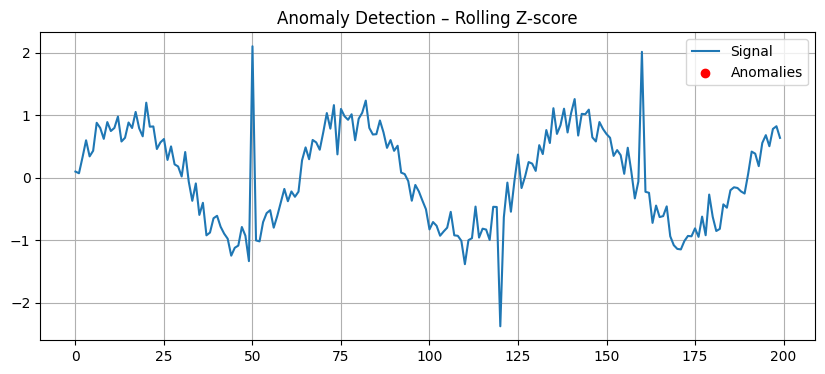

In [8]:
# Rolling Z-score detection
rolling_mean = pd.Series(signal).rolling(window=10).mean()
rolling_std = pd.Series(signal).rolling(window=10).std()
z_scores = (signal - rolling_mean) / rolling_std
anomalies = np.where(np.abs(z_scores) > 3)[0]

# Plot anomalies (statistical approach)
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Signal")
plt.scatter(anomalies, signal[anomalies], color='red', label="Anomalies")
plt.title("Anomaly Detection – Rolling Z-score")
plt.legend()
plt.grid(True)
plt.show()



In [9]:
# 2. Deep Learning Approach: Autoencoder
scaler = MinMaxScaler()
signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))

# Prepare sequences
def create_sequences(data, seq_len=20):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
    return np.array(X)

seq_len = 20
X = create_sequences(signal_scaled)
X_tensor = torch.FloatTensor(X)

In [10]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_len, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, seq_len)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

model = Autoencoder(seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


In [11]:
# Train autoencoder
for epoch in range(50):
    model.train()
    output = model(X_tensor.squeeze(-1))
    loss = criterion(output, X_tensor.squeeze(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

Epoch 10, Loss: 0.089313
Epoch 20, Loss: 0.024138
Epoch 30, Loss: 0.019886
Epoch 40, Loss: 0.014192
Epoch 50, Loss: 0.010853


In [12]:
 # Compute reconstruction error
model.eval()
with torch.no_grad():
    recon = model(X_tensor.squeeze(-1)).numpy()
    errors = np.mean((X.squeeze() - recon) ** 2, axis=1)

# Threshold and detect
threshold = np.percentile(errors, 95)
anomaly_idx = np.where(errors > threshold)[0]


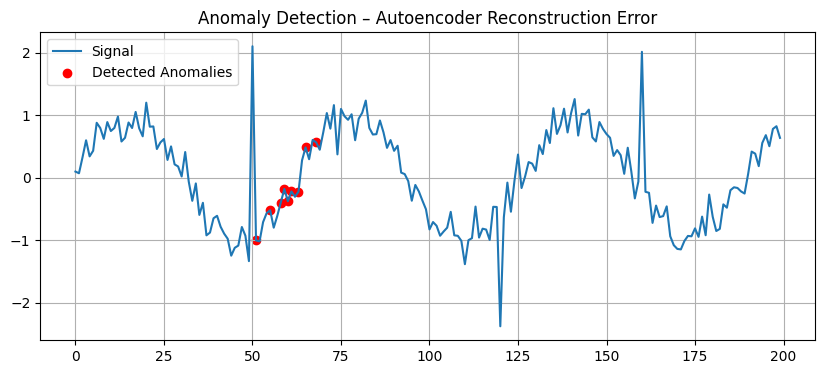

In [13]:
 # Plot deep learning anomaly detection
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Signal")
plt.scatter(anomaly_idx + seq_len, signal[anomaly_idx + seq_len], color='red', label="Detected Anomalies")
plt.title("Anomaly Detection – Autoencoder Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()